In [1]:
##################################################
# Imports
##################################################
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import keras 
from sklearn.neighbors import KNeighborsClassifier
import sklearn.discriminant_analysis
from copy import deepcopy
import sklearn
import sklearn.neighbors
import sklearn.semi_supervised
import random
import os

##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/kaggle/input/ml-project-speech-recognition-challenge'
SAMPLE_RATE = 16000
HOP_LEN = 512

##################################################
# Set seeds
##################################################

seed = 0
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

# Dataset

The dataset is a reduced version of the [`TensorFlow Speech Commands Dataset`](https://www.tensorflow.org/datasets/catalog/speech_commands) and contains audio waveforms of the words:
- `down`, 
- `go`, 
- `left`, 
- `off`, 
- `on`, 
- `right`, 
- `stop`, 
- `up`.


Train / Validation Split
- 1600 train samples, 200 for each class
- 109 validation samples

In [2]:
##################################################
# Load dataset
##################################################


#Importing the dataset and all the libraries
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ml-project-speech-recognition-challenge

#unzip files

! unzip train_audio.npy.zip
!unzip validation_audio.npy.zip
! unzip validation_feat.npy.zip
! unzip train_feat.npy.zip

  0% 0.00/13.4k [00:00<?, ?B/s]
100% 13.4k/13.4k [00:00<00:00, 23.3MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.5MB/s]
 55% 25.0M/45.2M [00:00<00:00, 41.1MB/s]
100% 45.2M/45.2M [00:00<00:00, 77.2MB/s]
  0% 0.00/0.98k [00:00<?, ?B/s]
100% 0.98k/0.98k [00:00<00:00, 1.02MB/s]
  0% 0.00/3.87M [00:00<?, ?B/s]
100% 3.87M/3.87M [00:00<00:00, 128MB/s]
 58% 25.0M/43.4M [00:00<00:00, 44.8MB/s]
100% 43.4M/43.4M [00:00<00:00, 80.6MB/s]
  0% 0.00/806 [00:00<?, ?B/s]
100% 806/806 [00:00<00:00, 1.14MB/s]
  0% 0.00/2.99M [00:00<?, ?B/s]
100% 2.99M/2.99M [00:00<00:00, 188MB/s]
Archive:  train_audio.npy.zip
  inflating: train_audio.npy         
Archive:  validation_audio.npy.zip
  inflating: validation_audio.npy    
Archive:  validation_feat.npy.zip
  inflating: validation_feat.npy     
Archive:  train_feat.npy.zip
  inflating: train_feat.npy          


In [3]:
# Load annotations
df_train = pd.read_csv('train.csv')
df_validation = pd.read_csv('validation.csv')
labels = sorted(list(set(df_train['word'].values)))
y_train = df_train['word'].map(lambda w: labels.index(w)).values
y_validation = df_validation['word'].map(lambda w: labels.index(w)).values

In [4]:
##################################################
# Function for one_hot_encoding the labels
##################################################

enumerate_words = dict([reversed(el) for el in enumerate(sorted(list(set(df_train['word']))))])


def one_hot_encoding(labels, word_list = enumerate_words  ):

  '''
  INPUTS : 
  labels = list of labels
  word_list = list of correspondencies between labels and indexes

  OUTPUT : 
  y = nparray of the one_hot_encoded labels
  '''

  y = np.zeros((len(labels),len(word_list)))

  n_words = len(word_list)

  for i in range(len(labels)):

    y[i]  = np.identity(n_words)[word_list[labels[i]]]

  return y

In [5]:
# Load audio
train_audio  = np.load('train_audio.npy')
validation_audio  = np.load('validation_audio.npy')

# One hot encoding the labels

train_labels = one_hot_encoding(df_train['word'])
validation_labels = one_hot_encoding(df_validation['word'])

# Feature Extraction

The speech is a time series signal and a well known strategy for extracting a good representation of the raw audio is to mimic the processing of the auditory system of the humans. A well established feature representation for speech is the so called "log mel-spectrum". This feature in fact, takes into account how humans perceive both the frequencies and the amplitude of the sound logarithmically. If you want to dig more into this topic [here](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9) you can find some details. 

![auditory-system](https://www.researchgate.net/profile/Morteza_Khaleghi_Meybodi/publication/322343133/figure/fig1/AS:581011472093184@1515535337239/Figure-31-Schematic-of-the-auditory-system-with-its-primary-components-including.png)


For this project these features are precomputed: for each audio waveform of 1 sec duration, the log mel-spectrum is a bi-dimensional representation (frequency vs time) of shape [128, 32]. Here, we first resize the "image" into a [32, 32] matrix and then we flatten the representation into a 32x32 = 1024 vector.

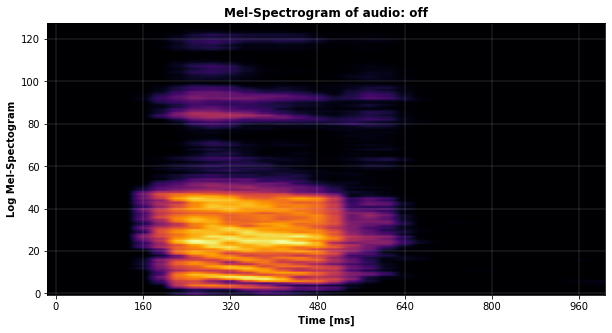

In [6]:
# Load Features
train_feat = np.load('train_feat.npy')
validation_feat = np.load('validation_feat.npy')


# Plot audio feature
idx = 1205
time = np.arange(1, SAMPLE_RATE + 1, HOP_LEN) / SAMPLE_RATE
plt.figure(figsize=(10, 5))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(train_feat[idx], aspect='auto', origin='low', cmap='inferno')
xticks = plt.xticks()[0].astype(np.int32)
plt.xticks(xticks[1:-1], [f'{1000 * t:.0f}' for t in time[xticks[1:-1]]])
plt.xlabel('Time [ms]', fontweight='bold')
plt.ylabel('Log Mel-Spectogram', fontweight='bold')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(train_audio[idx], rate=SAMPLE_RATE)

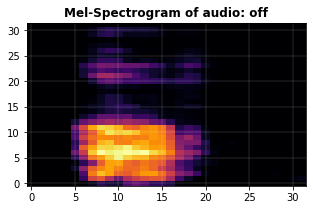

In [7]:
# Resize all log-mel spectrograms

x_train = []
for x_i in train_feat:
    x_train += [cv2.resize(x_i, (32, 32))]
train_feat= np.array(x_train)
x_validation = []
for x_i in validation_feat:
    x_validation += [cv2.resize(x_i, (32, 32))]
validation_feat = np.array(x_validation)


test_feat = validation_feat
test_labels = validation_labels

#expanded version of Log-mel spectrogram for CNN

train_feat_expanded = tf.expand_dims(train_feat,-1)                            
validation_feat_expanded = tf.expand_dims(validation_feat,-1)


# Plot audio feature
idx = 1205
plt.figure(figsize=(5, 3))
plt.title(f'Mel-Spectrogram of audio: {df_train["word"][idx]}', fontweight='bold')
plt.imshow(train_feat[idx], aspect='auto', origin='low', cmap='inferno')
plt.grid(lw=0.4, c='w', alpha=0.4)
plt.show()

# Play audio
ipd.Audio(train_audio[idx], rate=SAMPLE_RATE)

In [8]:
seed = 0
np.random.seed(seed = seed)

a = np.sort(np.random.choice(range(0, 199), size=40, replace=False))
for i in range(1,8):
    a = np.concatenate([a, np.sort(np.random.choice(range(0+i*200, 199+i*200), size=40, replace=False))])


b = [el for el in range(train_feat.shape[0]) if el not in a ]

train_feat,train_labels,validation_feat,validation_labels  = train_feat[b],train_labels[b],train_feat[a], train_labels[a]


# Flatten the features
train_feat_flat = train_feat.reshape(train_feat.shape[0], -1)
train_labels = train_labels.reshape(train_labels.shape[0], -1)

validation_feat_flat = validation_feat.reshape(validation_feat.shape[0], -1)
validation_labels = validation_labels.reshape(validation_labels.shape[0], -1)

test_feat_flat= test_feat.reshape(test_feat.shape[0], -1)
test_labels = test_labels.reshape(test_labels.shape[0], -1)

# Expand dimension for CNN model

train_feat_expanded = tf.expand_dims(train_feat,-1)                            
validation_feat_expanded = tf.expand_dims(validation_feat,-1)
test_feat_expanded = tf.expand_dims(test_feat,-1)

# Model

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)

The best model I've been able to get is a convolutional neural network applied to the spectrograms.

In [9]:
##################################################
# Functions for plotting NN results
##################################################

def plot_loss(history):

  fig = plt.figure()
  ax = fig.add_subplot()
  ax.plot(history.epoch,history.history['loss'],label = 'train loss')
  ax.plot(history.epoch,history.history['val_loss'],label = 'validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

def plot_accuracy(history):

  fig = plt.figure()
  ax = fig.add_subplot()
  ax.plot(history.epoch,history.history['accuracy'],label = 'train accuracy')
  ax.plot(history.epoch,history.history['val_accuracy'],label = 'validation accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2900    

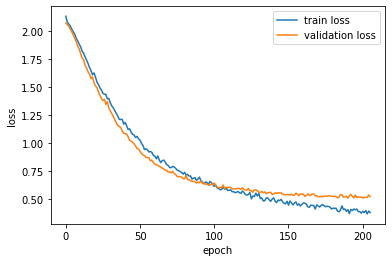

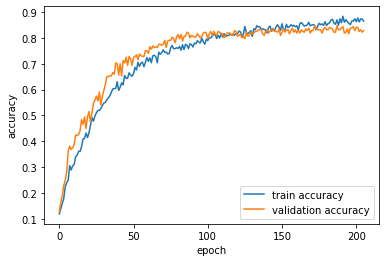

-----------------------------------------------------------
train loss: 0.23
train  accuracy: 94.14%
-----------------------------------------------------------
validation loss: 0.51
validation  accuracy: 83.75%
-----------------------------------------------------------
test loss: 0.28
test  accuracy: 88.99%
-----------------------------------------------------------


In [11]:
##################################################
# Implement you model here
##################################################

#CNN

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.4,seed = seed),   
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ]  ,  name = 'CNN'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_expanded,train_labels,epochs = 300 , batch_size=128,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback], verbose = 0
                    )

plot_loss(history)
plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0)   

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

## EXPERIMENT 1 : Robustness to translations

Model: "Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                82000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 408       
Total params: 86,458
Trainable params: 86,458
Non-trainable params: 0
_________________________________________________________

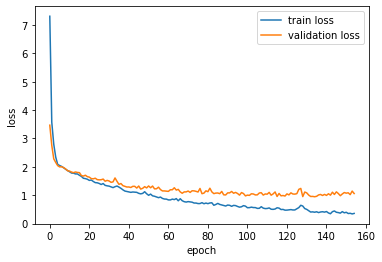

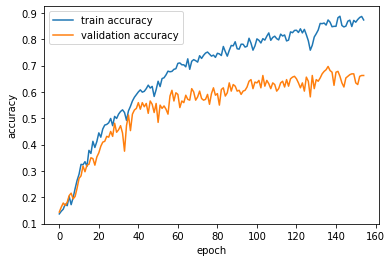

-----------------------------------------------------------
train loss: 0.32
train  accuracy: 89.53%
-----------------------------------------------------------
validation loss: 0.95
validation  accuracy: 67.81%
-----------------------------------------------------------
test loss: 0.67
test  accuracy: 77.98%
-----------------------------------------------------------


In [12]:
#Dense version

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model_dense = tf.keras.models.Sequential([
                                          tf.keras.layers.Input(shape = train_feat[0].shape),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(units = 80,activation='relu'),
                                          tf.keras.layers.Dropout(rate = 0.0, seed = seed ),
                                          tf.keras.layers.Dense( units = 50, activation='relu'),
                                          tf.keras.layers.Dropout(rate=0.05, seed = seed ),
                                          tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                          ] , name = 'Dense'
                                         )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model_dense.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model_dense.summary()

history = model_dense.fit(train_feat,train_labels,epochs = 200 ,batch_size=128,
                          validation_data=(validation_feat,validation_labels),
                          callbacks=[callback],verbose = 0
                          )

plot_loss(history)
plot_accuracy(history)

scores_train = model_dense.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model_dense.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model_dense.evaluate(test_feat_expanded, test_labels, verbose=0)   

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

In [10]:
##################################################
# Accuracy function
##################################################

def accuracy(model,x_test, y_test,one_hot = True):
    '''
    input model: model to be evaluated, in this case Svm or knn
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape 
    input one_hot : True if the y_test is given in one hot encoding form
    '''
    y_pred = model.predict(x_test)

    if one_hot == True:

      y_true = np.argmax(y_test,axis=1)

    else:

      y_true = y_test

    return (1.0 * (y_pred == y_true)).mean()


##################################################
# Translation function
##################################################

def translation(image_set,tx):

  '''
  input image_set : image set, each image of shape (32,32,1)
  input tx : amount of translation to apply to each image, negative for translations
            to the left
  '''

  translated = np.zeros(image_set.shape)

  for i in range(image_set.shape[0]):

    img = image_set[i,:,:,0]
    num_rows, num_cols = 32,32

    if tx>=0:
      img_translation = np.hstack((-9.2*np.ones(shape=(32,np.abs(tx))),img))  
    else:
      img_translation = np.hstack((img,-9.2*np.ones(shape=(32,np.abs(tx)))))

    img_translation = img_translation[:,np.max([-tx,0]):img_translation.shape[1]-np.max([tx,0])]
    img_translation = tf.expand_dims(img_translation,axis=-1)
    translated[i] = img_translation

  return translated

In [14]:
#SVM

sv = sklearn.svm.SVC(C = 2)
sv.fit(train_feat_flat,np.argmax(train_labels,axis=1))

#KNN

knn = KNeighborsClassifier(n_neighbors=7,weights = 'distance')
knn.fit(train_feat_flat,np.argmax(train_labels,axis=1))

# test on the time translated samples

T_max = 20
tx = np.arange(-T_max,T_max,1)

accuracy_conv = []
accuracy_dense = []
accuracy_svm = []
accuracy_knn = []


for t in tx:

  translated = translation(test_feat_expanded,t)
  translated_flatten = translated[:,:,:,0].reshape( (test_feat.shape[0],32*32))

  translated_accuracy_dense = model_dense.evaluate(x = translated, y = test_labels  , verbose = 0)[1]
  translated_accuracy_cnn = model.evaluate(x = translated, y = test_labels  , verbose = 0)[1]
  translated_accuracy_svm = accuracy( sv, translated_flatten , test_labels   )
  translated_accuracy_knn = accuracy(knn, translated_flatten , test_labels   )

  accuracy_dense.append(translated_accuracy_dense)
  accuracy_conv.append(translated_accuracy_cnn)
  accuracy_svm.append(translated_accuracy_svm)
  accuracy_knn.append(translated_accuracy_knn)

accuracy_dense = np.array(accuracy_dense)
accuracy_conv = np.array(accuracy_conv)
accuracy_svm = np.array(accuracy_svm)
accuracy_knn = np.array(accuracy_knn)

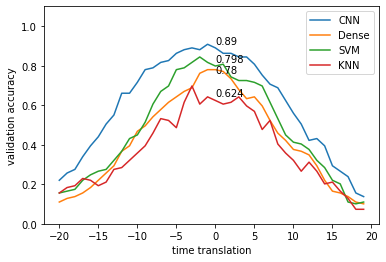

In [15]:
#fullplot

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tx,accuracy_conv,label = 'CNN')
ax.plot(tx,accuracy_dense,label = 'Dense')
ax.plot(tx,accuracy_svm,label = 'SVM')
ax.plot(tx,accuracy_knn,label = 'KNN')
plt.xlabel('time translation')
plt.ylabel('validation accuracy')
plt.legend()

y0_cnn = accuracy_conv[tx==0][0]
ax.annotate(np.round(y0_cnn,3), xy=(0, y0_cnn), xytext=(0, y0_cnn+0.02))

y0_dense = accuracy_dense[tx==0][0]
ax.annotate(np.round(y0_dense,3), xy=(0, y0_dense), xytext=(0, y0_dense-0.02))

y0_svm = accuracy_svm[tx==0][0]
ax.annotate(np.round(y0_svm,3), xy=(0, y0_svm), xytext=(0, y0_svm+0.02))

y0_knn = accuracy_knn[tx==0][0]
ax.annotate(np.round(y0_knn,3), xy=(0, y0_knn), xytext=(0, y0_knn+0.02))

ax.set_ylim(0,1.1)
plt.show()

### AFTER AUGMENTING

The main idea here is to construct a parametric family of transformations $f_{\theta}$ that keeps the meaning of the data and preserves the labels (in our example translations do, we know that a time translated audio does not change its meaning). Geometrically, this means that we have prior knowledge of some degrees of freedoms of the data manifold ( for example if $\theta$ is a scalar $\theta \rightarrow f_{\theta}(x)$ describes a curve on the data manifold for every $x$).

 We would like to encode this prior information in our model, in other words we would like it to be robust with respect to the family of transformations $f_{\theta}$.
More formally, we would like that $\hat{p}(y|x)\approx \hat{p}(y|f_{\theta}(x))$.

In this experiment I tried to see what's the difference in performance and in translation robustness in feeding a translation-augmented training dataset to the neural network.

In [11]:
# Augmenting the dataset with translations

tx = np.arange(-8,8,1) 

train_feat_augmented = []
train_labels_augmented = list(deepcopy(train_labels))


for t in tx:

  train_feat_augmented.extend(translation(train_feat_expanded,t))
  train_labels_augmented.extend(train_labels)

train_feat_augmented = np.vstack(  (  train_feat_expanded  ,  np.array(train_feat_augmented)     )   )
train_labels_augmented = np.array(train_labels_augmented)
  

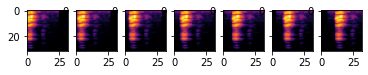

In [17]:
s#Example of translation


for i in range(1,8,1): 

  plt.subplot(1,len(range(1,8,1)),i) 
  plt.imshow(train_feat_augmented[2*i*train_feat.shape[0],:,:,0],cmap = 'inferno')

plt.rcParams["figure.figsize"] = (40,10)
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Model: "CNN_translation_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)  

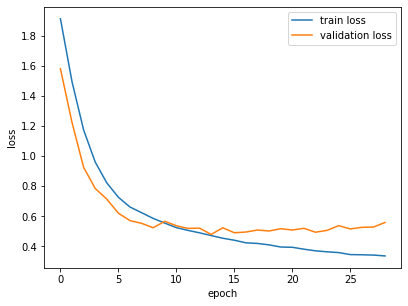

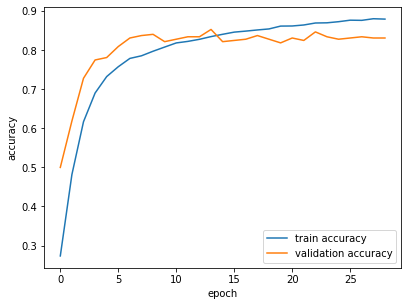

-----------------------------------------------------------
train loss: 0.26
train  accuracy: 91.64%
-----------------------------------------------------------
validation loss: 0.48
validation  accuracy: 85.31%
-----------------------------------------------------------
test loss: 0.17
test  accuracy: 95.41%
-----------------------------------------------------------


In [18]:
##################################################
# CNN with translation-augmented dataset
##################################################

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.2,seed = seed),   
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ] , name = 'CNN_translation_augmented'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_augmented,train_labels_augmented,epochs = 200 , batch_size=128,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback], verbose = 0
                    )

plot_loss(history)

plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0)   

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

Model: "Dense_translation_augmented"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                82000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 408       
Total params: 86,458
Trainable params: 86,458
Non-trainable params: 0
_________________________________________________________________


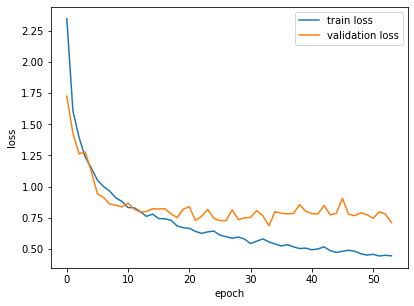

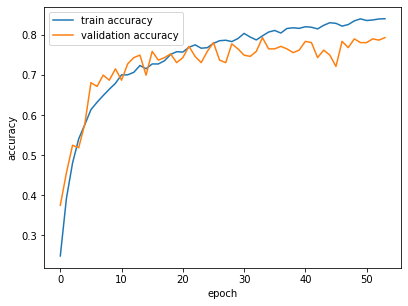

-----------------------------------------------------------
train loss: 0.33
train  accuracy: 87.73%
-----------------------------------------------------------
validation loss: 0.69
validation  accuracy: 79.37%
-----------------------------------------------------------
test loss: 0.49
test  accuracy: 86.24%
-----------------------------------------------------------


In [19]:
#Dense version

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model_dense = tf.keras.models.Sequential([
                                          tf.keras.layers.Input(shape = train_feat[0].shape),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(units = 80,activation='relu'),
                                          tf.keras.layers.Dropout(rate = 0.02, seed = seed ),
                                          tf.keras.layers.Dense( units = 50, activation='relu'),
                                          tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                          ] , name = 'Dense_translation_augmented'
                                         )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model_dense.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model_dense.summary()

history = model_dense.fit(train_feat_augmented,train_labels_augmented,epochs = 200 , batch_size=128,
                          validation_data=(validation_feat,validation_labels),
                          callbacks=[callback],verbose = 0
                          )

plot_loss(history)

plot_accuracy(history)

scores_train = model_dense.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model_dense.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model_dense.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model_dense.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model_dense.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model_dense.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model_dense.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model_dense.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model_dense.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

In [20]:
#SVM
train_feat_augmented_flatten = train_feat_augmented.reshape((train_feat_augmented.shape[0],32*32))

sv = sklearn.svm.SVC(C = 2)
sv.fit(train_feat_augmented_flatten,np.argmax(train_labels_augmented,axis=1))

#KNN

knn = KNeighborsClassifier(n_neighbors=7,weights = 'distance')
knn.fit(train_feat_augmented_flatten,np.argmax(train_labels_augmented,axis=1))


# test on the time translated samples

T_max = 20
tx = np.arange(-T_max,T_max,1)

accuracy_cnn = []
accuracy_dense = []
accuracy_svm = []
accuracy_knn = []



for t in tx:

  translated = translation(test_feat_expanded,t)
  translated_flatten = translated[:,:,:,0].reshape( (test_feat.shape[0],32*32)  ) 

  translated_accuracy_dense = model_dense.evaluate(translated,test_labels,verbose = 0)[1]
  translated_accuracy_cnn = model.evaluate(translated,test_labels,verbose = 0)[1]
  translated_accuracy_svm = accuracy(sv,translated_flatten,test_labels)
  translated_accuracy_knn = accuracy(knn,translated_flatten,test_labels)

  accuracy_dense.append(translated_accuracy_dense)
  accuracy_cnn.append(translated_accuracy_cnn)
  accuracy_svm.append(translated_accuracy_svm)
  accuracy_knn.append(translated_accuracy_knn)

accuracy_dense = np.array(accuracy_dense)
accuracy_cnn = np.array(accuracy_cnn)
accuracy_svm = np.array(accuracy_svm)
accuracy_knn = np.array(accuracy_knn)

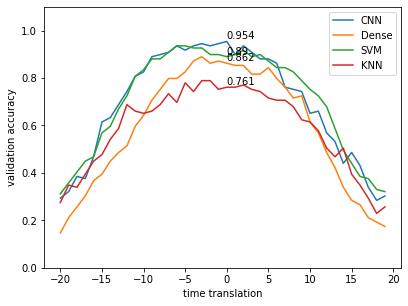

In [21]:
#fullplot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(tx,accuracy_cnn,label = 'CNN')
ax.plot(tx,accuracy_dense,label = 'Dense')
ax.plot(tx,accuracy_svm,label = 'SVM')
ax.plot(tx,accuracy_knn,label = 'KNN')
plt.xlabel('time translation')
plt.ylabel('validation accuracy')
plt.legend()

y0_cnn = accuracy_cnn[tx==0][0]
ax.annotate(np.round(y0_cnn,3), xy=(0, y0_cnn), xytext=(0, y0_cnn+0.01) )

y0_dense = accuracy_dense[tx==0][0]
ax.annotate(np.round(y0_dense,3), xy=(0, y0_dense), xytext=(0, y0_dense+0.01))

y0_svm = accuracy_svm[tx==0][0]
ax.annotate(np.round(y0_svm,3), xy=(0, y0_svm), xytext=(0, y0_svm+0.01) )

y0_knn = accuracy_knn[tx==0][0]
ax.annotate(np.round(y0_knn,3), xy=(0, y0_knn), xytext=(0, y0_knn+0.01))

ax.set_ylim(0,1.1)
plt.show()

# Experiment 2 : robustness to artificial noise

In [12]:
#############################################
# Function for adding noise to the samples
#############################################

def gaussian_noise_augmenting(x_train,y_train,p=0.9,variance=1/32,n_copies=10,seed=0):

  '''
  input x_train : nparray of size (n_samples,height_sample,length_sample,1)
  input y_train : nparray of size (n_samples,n_classes)
  input p : probability of not perturbing an entry
  input variance : variance of the normal distribution
  input n_copies : number of copies of the dataset
  input seed : seed for the random functions inside

  output x_noisy : augmented dataset with gaussian sparse noise
  output y_noisy : augmented labels matrix
  '''

  np.random.seed(seed)

  x_noisy = deepcopy(x_train)
  y_noisy = deepcopy(y_train)


  for _ in range(n_copies):


    noise = np.random.normal(size = x_train[:,:,:,0].shape,scale = variance )*np.random.choice([0,1],size = x_train[:,:,:,0].shape,p=[p,1-p])

    x_noisy = np.vstack( ( x_noisy,tf.expand_dims(x_train[:,:,:,0] + noise ,axis=-1 )  )   ) 
    y_noisy = np.vstack((y_noisy,y_train))

  return x_noisy,y_noisy

  

def salt_and_pepper_masking_augmenting(x_train,y_train,p=0.9,n_copies=10,seed=0):

  '''
  input x_train : nparray of size (n_samples,height_sample,length_sample,1)
  input y_train : nparray of size (n_samples,n_classes)
  input p : probability of not perturbing an entry
  input n_copies : number of copies of the dataset
  input seed : seed for the random functions inside

  output x_noisy : augmented dataset with salt and pepper masking
  output y_noisy : augmented labels matrix
  '''

  np.random.seed(seed)
  x_noisy = deepcopy(x_train)
  y_noisy = deepcopy(y_train)

  for _ in range(n_copies):

    mask = np.random.choice([0,1],size = x_train[:,:,:,0].shape,p=[p,1-p])
    x_noisy = np.vstack( ( x_noisy,tf.expand_dims(x_train[:,:,:,0] -x_train[:,:,:,0]*mask-9.2*mask  ,axis=-1 )))  #.7,.3
    y_noisy = np.vstack((y_noisy,y_train))

  return x_noisy,y_noisy

### Salt and pepper test

In [50]:
###############################################
# salt and pepper noisy samples generation
###############################################

train_feat_noisy ,train_labels_noisy = salt_and_pepper_masking_augmenting(train_feat_expanded,train_labels)

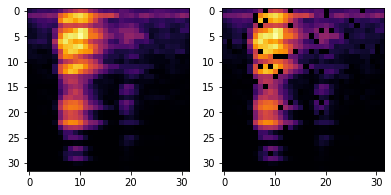

In [51]:
#Example of noise

plt.subplot(121) 
plt.imshow(train_feat_noisy[0,:,:,0],cmap='inferno')
plt.subplot(122)
plt.imshow(train_feat_noisy[len(train_feat),:,:,0],cmap='inferno')
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Model: "CNN_noise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 144)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 20)                29

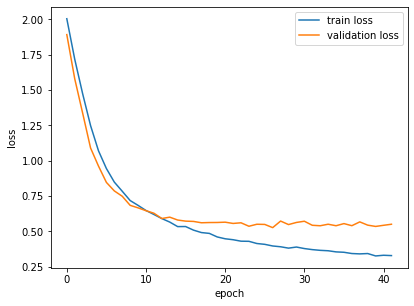

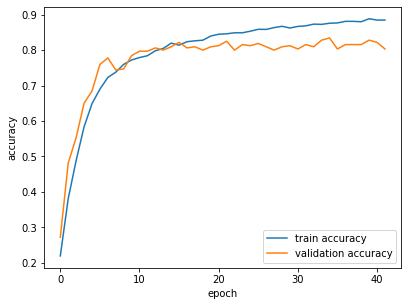

-----------------------------------------------------------
train loss: 0.20
train  accuracy: 95.47%
-----------------------------------------------------------
validation loss: 0.53
validation  accuracy: 80.94%
-----------------------------------------------------------
test loss: 0.27
test  accuracy: 91.74%
-----------------------------------------------------------


In [57]:
################################################################
# CNN with salt and pepper  noise injection in the training data
################################################################

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.25,seed = seed),   #.3
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ] , name = 'CNN_noise'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_noisy,train_labels_noisy,epochs = 300 , batch_size=128,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback], verbose = 0
                    )

plot_loss(history)
plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

Model: "Dense_noise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 80)                82000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 408       
Total params: 86,458
Trainable params: 86,458
Non-trainable params: 0
_________________________________________________________________


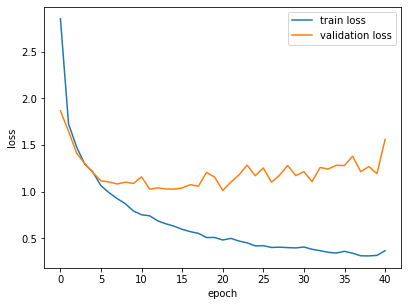

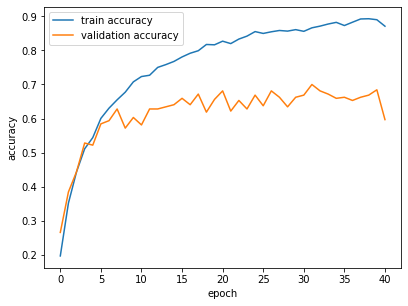

-----------------------------------------------------------
train loss: 0.28
train  accuracy: 91.25%
-----------------------------------------------------------
validation loss: 1.01
validation  accuracy: 68.12%
-----------------------------------------------------------
test loss: 0.67
test  accuracy: 75.23%
-----------------------------------------------------------


In [26]:
#Dense version

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model_dense = tf.keras.models.Sequential([
                                          tf.keras.layers.Input(shape = train_feat[0].shape),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(units = 80,activation='relu'),
                                          tf.keras.layers.Dropout(rate = 0.05, seed = seed ),
                                          tf.keras.layers.Dense( units = 50, activation='relu'),
                                          tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                          ], name = 'Dense_noise'
                                         )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model_dense.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model_dense.summary()

history = model_dense.fit(train_feat_noisy,train_labels_noisy,epochs = 200 , batch_size=128,
                          validation_data=(validation_feat,validation_labels),
                          callbacks=[callback],verbose = 0
                          )

plot_loss(history)

plot_accuracy(history)

scores_train = model_dense.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model_dense.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model_dense.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model_dense.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model_dense.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model_dense.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model_dense.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model_dense.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model_dense.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

In [27]:
train_feat_noisy_flatten = train_feat_noisy.reshape((train_feat_noisy.shape[0],32*32))

sv = sklearn.svm.SVC(C = 2)
sv.fit(train_feat_noisy_flatten,np.argmax(train_labels_noisy,axis=1))

#KNN

knn = KNeighborsClassifier(n_neighbors=7,weights = 'distance')
knn.fit(train_feat_noisy_flatten,np.argmax(train_labels_noisy,axis=1))

print('-----------------------------------------')
print('knn accuracy: ', accuracy(knn,test_feat_flat,test_labels))   
print('-----------------------------------------')
print('svm accuracy: ', accuracy(sv,test_feat_flat,test_labels))     

-----------------------------------------
knn accuracy:  0.5871559633027523
-----------------------------------------
svm accuracy:  0.7889908256880734


### Gaussian sparse noise 

In [28]:
###############################################
# salt and pepper noisy samples generation
###############################################

train_feat_noisy_g ,train_labels_noisy_g = gaussian_noise_augmenting(train_feat_expanded,train_labels)

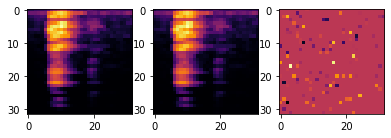

In [29]:
#Example of noise

plt.subplot(131) 
plt.imshow(train_feat_noisy_g[0,:,:,0],cmap='inferno')
plt.subplot(132)
plt.imshow(train_feat_noisy_g[len(train_feat),:,:,0],cmap='inferno')
plt.subplot(133)
plt.imshow(train_feat_noisy_g[0,:,:,0]-train_feat_noisy_g[len(train_feat),:,:,0],cmap='inferno')
plt.show()

Model: "CNN_gaussian_noise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 144)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 144)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)         

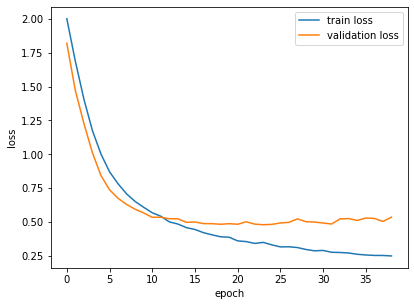

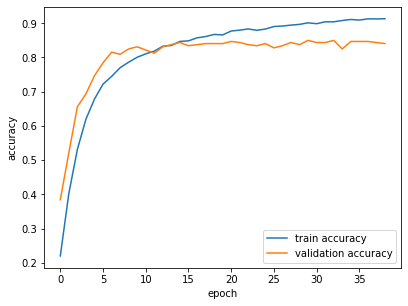

-----------------------------------------------------------
train loss: 0.16
train  accuracy: 96.17%
-----------------------------------------------------------
validation loss: 0.48
validation  accuracy: 83.44%
-----------------------------------------------------------
test loss: 0.26
test  accuracy: 92.66%
-----------------------------------------------------------


In [30]:
################################################################
# CNN with gaussian sparse noise injection in the training data
################################################################

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.4,seed = seed),
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ] , name = 'CNN_gaussian_noise'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_noisy_g,train_labels_noisy_g,epochs = 300 , batch_size=128,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback], verbose = 0
                    )

plot_loss(history)
plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

Model: "Dense_gaussian_noise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 80)                82000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 408       
Total params: 86,458
Trainable params: 86,458
Non-trainable params: 0
_________________________________________________________________


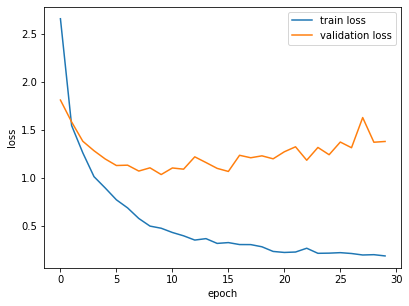

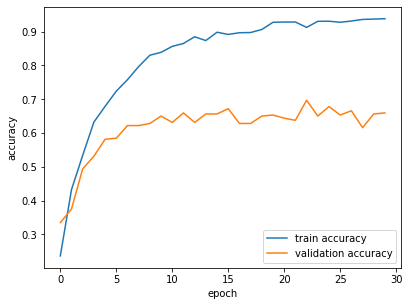

-----------------------------------------------------------
train loss: 0.32
train  accuracy: 90.47%
-----------------------------------------------------------
validation loss: 1.04
validation  accuracy: 65.00%
-----------------------------------------------------------
test loss: 0.74
test  accuracy: 75.23%
-----------------------------------------------------------


In [31]:
################################################################
# NN with gaussian sparse noise injection in the training data
################################################################

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model_dense = tf.keras.models.Sequential([
                                          tf.keras.layers.Input(shape = train_feat[0].shape),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(units = 80,activation='relu'),
                                          tf.keras.layers.Dropout(rate = 0.02, seed = seed ),
                                          tf.keras.layers.Dense( units = 50, activation='relu'),
                                          tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                          ], name = 'Dense_gaussian_noise'
                                         )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model_dense.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model_dense.summary()

history = model_dense.fit(train_feat_noisy_g,train_labels_noisy_g,epochs = 200 , batch_size=128,
                          validation_data=(validation_feat,validation_labels),
                          callbacks=[callback],verbose = 0
                          )

plot_loss(history)

plot_accuracy(history)

scores_train = model_dense.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model_dense.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model_dense.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model_dense.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model_dense.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model_dense.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model_dense.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model_dense.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model_dense.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

In [32]:
train_feat_noisy_g_flatten = train_feat_noisy_g.reshape((train_feat_noisy_g.shape[0],32*32))

sv = sklearn.svm.SVC(C = 2)
sv.fit(train_feat_noisy_g_flatten,np.argmax(train_labels_noisy_g,axis=1))

#KNN

knn = KNeighborsClassifier(n_neighbors=7,weights = 'distance')
knn.fit(train_feat_noisy_g_flatten,np.argmax(train_labels_noisy_g,axis=1))

print('-----------------------------------------')
print('knn accuracy: ', accuracy(knn,test_feat_flat,test_labels))   
print('-----------------------------------------')
print('svm accuracy: ', accuracy(sv,test_feat_flat,test_labels))    

-----------------------------------------
knn accuracy:  0.5321100917431193
-----------------------------------------
svm accuracy:  0.7981651376146789


### Frequency masking

In [13]:
######################################################
# Generation of augmented dataset
######################################################

def freq_mask(x_train_expanded,y_train,n_copies = 10,seed = 0):

  '''
  input x_train : nparray of size (n_samples,height_sample,length_sample,1)
  input y_train : nparray of size (n_samples,n_classes)
  input n_copies : number of copies of the dataset
  input seed : seed for the random functions inside

  output x_freqmask : augmented dataset with masked frequency bands
  output y_freqmask : augmented labels matrix
  '''

  x_train = np.array(x_train_expanded[:,:,:,0])

  np.random.seed(seed)

  x_freqmask = list(deepcopy(x_train))
  y_freqmask = list(deepcopy(y_train))

  for i in range(n_copies):  
  
    for j in range(x_train.shape[0]):

      delta_f = np.random.choice(range(1,4))
      f = np.random.choice(range(x_train.shape[1]))
      masked = deepcopy(x_train[j])
      index = np.array([ el for el in f+range(-delta_f,delta_f) if el in range(32)])
      masked[index] = masked[index]* np.zeros(shape = (index.shape[0],32)) -9.2        

      x_freqmask.append(masked)
      y_freqmask.append(y_train[j])

  x_freqmask = tf.expand_dims(np.array(x_freqmask),-1)
  y_freqmask = np.array(y_freqmask)

  return x_freqmask,y_freqmask

In [42]:
##################################################
# Frequency masking dataset generation
##################################################

seed = 0
train_feat_freqmask , train_labels_freqmask = freq_mask(train_feat_expanded,train_labels,10,seed)

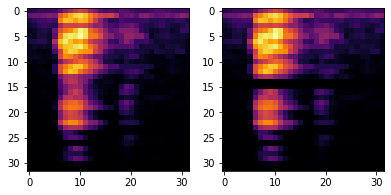

In [43]:
#Examples of frequency masking

plt.subplot(121) 
plt.imshow(train_feat_freqmask[0,:,:,0],cmap='inferno')
plt.subplot(122)
plt.imshow(train_feat_freqmask[len(train_feat),:,:,0],cmap='inferno')
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


Model: "CNN_freq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 144)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 144)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 20)                290

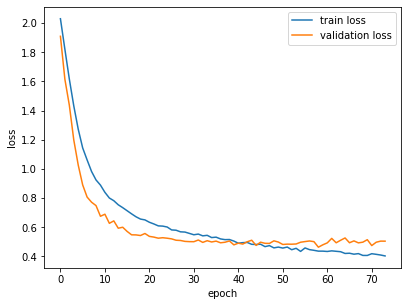

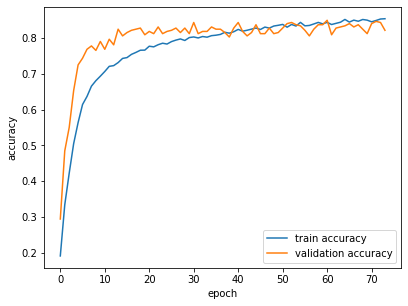

-----------------------------------------------------------
train loss: 0.14
train  accuracy: 96.09%
-----------------------------------------------------------
validation loss: 0.46
validation  accuracy: 83.75%
-----------------------------------------------------------
test loss: 0.27
test  accuracy: 90.83%
-----------------------------------------------------------


In [48]:
##################################################
# Implement you model here
##################################################

#CNN

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.4 ,seed = seed),    #0.5  
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ], name = 'CNN_freq'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_freqmask,train_labels_freqmask,epochs = 300 , batch_size=128,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback],verbose = 0
                    )

plot_loss(history)
plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

Model: "Dense_freq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 80)                82000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                4050      
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 408       
Total params: 86,458
Trainable params: 86,458
Non-trainable params: 0
_________________________________________________________________


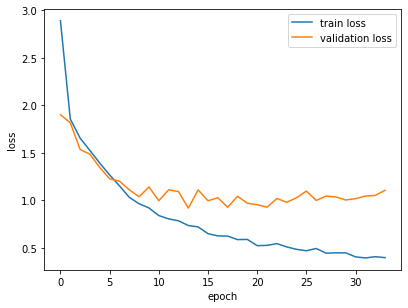

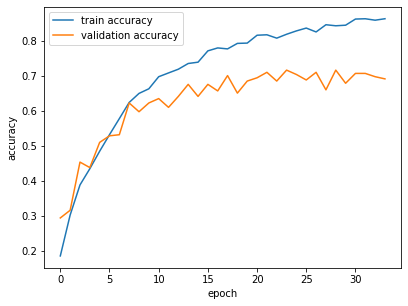

-----------------------------------------------------------
train loss: 0.42
train  accuracy: 86.33%
-----------------------------------------------------------
validation loss: 0.92
validation  accuracy: 67.50%
-----------------------------------------------------------
test loss: 0.68
test  accuracy: 77.06%
-----------------------------------------------------------


In [37]:
#Dense version

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model_dense = tf.keras.models.Sequential([
                                          tf.keras.layers.Input(shape = train_feat[0].shape),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(units = 80,activation='relu'),
                                          tf.keras.layers.Dropout(rate = 0.02, seed = seed ),
                                          tf.keras.layers.Dense( units = 50, activation='relu'),
                                          tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                          ],name = 'Dense_freq'
                                         )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model_dense.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model_dense.summary()

history = model_dense.fit(train_feat_freqmask,train_labels_freqmask,epochs = 200 , batch_size=128,
                          validation_data=(validation_feat,validation_labels),
                          callbacks=[callback],verbose = 0
                          )

plot_loss(history)
plot_accuracy(history)

scores_train = model_dense.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model_dense.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model_dense.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model_dense.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model_dense.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model_dense.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model_dense.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model_dense.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model_dense.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

# Final model with all augmentations

In [14]:
##################################################
# dataset with all augmentations
##################################################
n = train_feat_expanded.shape[0]
n_copies = 2   

train_feat_noisy_g,train_labels_noisy_g = gaussian_noise_augmenting(train_feat_augmented,train_labels_augmented,0.9,1/32,n_copies)
train_feat_noisy,train_labels_noisy = salt_and_pepper_masking_augmenting(train_feat_augmented,train_labels_augmented,0.9,n_copies)
train_feat_freqmask,train_labels_freqmask = freq_mask(train_feat_augmented,train_labels_augmented,n_copies)

train_feat_new = np.vstack(  (train_feat_augmented,train_feat_noisy_g[n:],train_feat_noisy[n:],train_feat_freqmask[n:]   )  )
train_labels_new = np.vstack(  (train_labels_augmented,train_labels_noisy_g[n:],train_labels_noisy[n:],train_labels_freqmask[n:]   )  )

Model: "CNN_all_augmentations"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 29, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dropout (Dropout)            (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 20)      

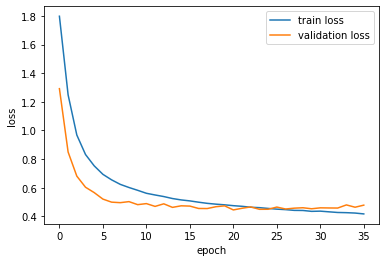

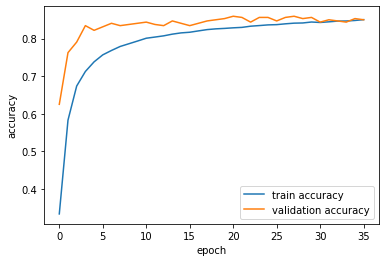

-----------------------------------------------------------
train loss: 0.16
train  accuracy: 95.86%
-----------------------------------------------------------
validation loss: 0.44
validation  accuracy: 85.94%
-----------------------------------------------------------
test loss: 0.15
test  accuracy: 94.50%
-----------------------------------------------------------


In [15]:
##################################################
# Implement you model here 
##################################################

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed = seed)
random.seed(seed)


model = tf.keras.models.Sequential([ 
                                    tf.keras.layers.Conv2D( kernel_size=4,activation = 'relu', filters=32,input_shape = train_feat_expanded[0].shape),
                                    tf.keras.layers.MaxPool2D(pool_size=3),
                                    tf.keras.layers.Conv2D( kernel_size = 3, filters=16 ,activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size = 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.3,seed = seed),    
                                    tf.keras.layers.Dense(units = 20, activation='sigmoid'), 
                                    tf.keras.layers.Dense(units = train_labels.shape[1],activation = 'softmax')
                                    ],name = 'CNN_all_augmentations'
                                   )


callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


model.compile(optimizer = 'Adam' , loss = "CategoricalCrossentropy",metrics = ['accuracy'])

model.summary()

history = model.fit(train_feat_new,train_labels_new,epochs = 300 , batch_size=128*10,
                    validation_data=(validation_feat_expanded,validation_labels),
                    callbacks=[callback],verbose = 0
                    )

plot_loss(history)
plot_accuracy(history)

scores_train = model.evaluate(train_feat_expanded, train_labels, verbose=0)  
scores_validation = model.evaluate(validation_feat_expanded, validation_labels, verbose=0)  
scores_test = model.evaluate(test_feat_expanded, test_labels, verbose=0) 

print('-----------------------------------------------------------')
print("train %s: %.2f" % (model.metrics_names[0], scores_train[0]))
print("train  %s: %.2f%%" % (model.metrics_names[1], scores_train[1]*100))
print('-----------------------------------------------------------')

print("validation %s: %.2f" % (model.metrics_names[0], scores_validation[0]))
print("validation  %s: %.2f%%" % (model.metrics_names[1], scores_validation[1]*100))
print('-----------------------------------------------------------')

print("test %s: %.2f" % (model.metrics_names[0], scores_test[0]))
print("test  %s: %.2f%%" % (model.metrics_names[1], scores_test[1]*100))
print('-----------------------------------------------------------')

# Evaluation

In [ ]:
##################################################
# Evaluate the model here
##################################################

# Use this function to evaluate your model
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.









# Send the submission for the challenge

In [ ]:
##################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = np.argmax(model.predict(test_feat_expanded),axis=1)

# Create submission
#submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))
#if y_test_pred is not None:
#   submission['class'] = [labels[int(y_i)] for y_i in y_test_pred]
#submission.to_csv('my_submission.csv', index=False)

submission = pd.read_csv('sample_submission.csv')
if y_test_pred is not None:
   submission['word'] = [labels[int(y_i)] for y_i in y_test_pred]
submission.to_csv('my_submission.csv', index=False)